In [83]:
# !pip install geopandas
# !pip install pgeocode
# !pip install folium
# !pip install pyshp
# !pip install haversine
# !pip install k-means-constrained
# !pip install k-means-constrained --target /opt/conda/lib/python3.8/site-packages
# !pip install --upgrade numpy --target /opt/conda/lib/python3.8/site-packages

In [1]:
import geopandas as gpd
import fiona

In [2]:
# 1) Get fake jobs for zipcodes in Orlando
# 2) Get problem descriptions for the jobs and predict parts START HERE
# 3) Create part stock list - top 10 model ice maker kits
# 4) Flag same day fix
# 5) run against current availibility mapping with agents

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import random
import sqlalchemy, os
import pandas as pd
import numpy as np
np.random.seed(201912)
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pickle
from retail_toolkit import atlas
from retail_toolkit import credential_manager as cm
from numpy import average
import time

In [5]:
import requests
import json
from collections import Counter
from random import choices

In [6]:
import folium
from folium import plugins
# import geopandas as gpd
from folium.plugins import HeatMap
from shapely.geometry import Point, Polygon
import shapefile
from IPython.display import display

In [7]:
from k_means_constrained import KMeansConstrained

In [8]:
import pgeocode
from haversine import haversine, Unit
from kneed import KneeLocator

In [9]:
# Applying simple kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

In [10]:
# import get_coverage
import color_scheme
mapping = color_scheme.create_mapping()

In [11]:
def get_demand():
    presto_connection =  atlas.Presto(environment = 'presto://{}:{}@atlas-workbench-presto.atlas.prd.aws.asurion.net:18443/hive').connect()
    sql = """
    select distinct
        sj.service_order_id ,
        so.service_order_number,
        sj.service_job_type_id ,
        sj.payment_type ,
        sj.sj_program_id ,
        sj.external_reference_number ,
        sj.crm_number ,
        sj.service_job_id ,
        sj.service_job_number ,
        sj.service_job_status ,
        sj.service_job_sub_status ,
        sj.service_job_date,
        sj.service_job_source ,
        sj.service_request_type_code ,
        sj.technician_routing_status ,
        sj.technician_routing_message ,
        sj.route_order_number ,
        sj.scheduled_service_date,
        coalesce(o.orig_sched_dt, sj.scheduled_service_date) orig_service_dt ,
        sj.problem_description ,
        sj.service_explanation ,
        sj.technician_id ,
        rs.retailer_store_name,
        sprd.model_number,
        sprd.model_version,
        sprd.serial_number,
        sprd.internal_brand_code ,
        sprd.purchase_date ,
        sprd.purchase_price ,
        sprd.manufacturer ,
        sjpl.description industry,
        ftf.min_tech_arrival_dt,
        ftf.min_complete_dt,
        cus.address_line_1 addr_line_1,
        cus.address_city,
        cus.address_province addr_state,
        cus.address_postal_code addr_zip_code,
        dl.name
    from
        hive.rtm_analytics.l2_odhsb_sbv5_at_service_job_rs sj 
        join hive.rtm_analytics.l2_odhsb_sbv5_at_service_order_rs so on so.service_order_id = sj.service_order_id 
        left join hive.rtm_analytics.l2_odhsb_sbv5_at_sj_part_rs sjp on sj.service_job_id = sjp.service_job_id
        join hive.rtm_analytics.l2_odhsb_sbv5_at_sa_retailer_store_rs rs on	sj.retailer_store_id = rs.retailer_store_id
        join hive.l2_retail.odhsb_sbv5_at_so_product sprd on sprd.service_order_id = so.service_order_id 
        join hive.l2_retail.odhsb_sbv5_at_sa_service_job_product_line sjpl on sjpl.sj_product_line_id = sprd.sj_product_line_id 
        join hive.l2_retail.odhsb_sbv5_st_txn_contact cus on cus.txn_id = sj.service_order_id and contact_type = 0
        left join hive.l2_retail.odhsb_sb_svbt_dispatch_zone z on sj.sj_zone_id = z.zone_id_char
        left join hive.l2_retail.odhsb_sb_svbt_dealer_location dl on z.dealer_location_id = dl.dealer_location_id
        left join (
            select
                entity_id,
                min(date_parse(old_value , '%%m/%%d/%%Y')) orig_sched_dt
            from
                hive.rtm_analytics.l2_odhsb_sbv5_st_audit_field_rs
            where
                owner_company_id = '43'
                and field_id = 'scheduledServiceDate'
                and cast(audit_date as date) >= date '2021-01-01'
            group by 1
        ) o on sj.service_job_id = o.entity_id
        left join (
            select 
                so.service_order_id,
                min(case when au.new_value = 'TAR' then au.audit_dateutc end) min_tech_arrival_dt,
                min(case when au.new_value in ('AAA','AWT','ACU','RTC','AAK','AAJ','ABB','ABC','ACP','ACQ','ACR','ACV') then au.audit_dateutc end) min_complete_dt
            from
                hive.rtm_analytics.l2_odhsb_sbv5_st_audit_field_rs au
                join rtm_analytics.l2_odhsb_sbv5_at_service_job_rs  sj on au.entity_id = sj.service_job_id
                join l2_retail.odhsb_sbv5_at_service_order so on so.service_order_id = sj.service_order_id
                join rtm_analytics.l2_odhsb_sbv5_at_txn_exception_rs e on e.txn_id = sj.service_job_id
                join rtm_analytics.l2_odhsb_sbv5_at_txn_exception_detail_rs ed on ed.exception_id  = e.exception_id and ed.exception_code = 'PRE_DIAGNOSIS'
            where
                au.owner_company_id = '43'
                and cast(au.audit_date as date) >= date '2021-01-01'
                and au.field_id = 'serviceJobSubStatus'
            group by
                so.service_order_id
        ) ftf on ftf.service_order_id = so.service_order_id
    where
        --exception_code = 'PRE_DIAGNOSIS'
    -- 	and payment_type = 'CASHONDELIVERY'
    -- and retailer_store_name = 'Major Appliance - Samsung'
    --sjpl.description IN ('HOME REFRIGERATION' , 'HOME LAUNDRY ELEC', 'HOME LAUNDRY GAS', 'DISHWASHER')
        cast(sj.scheduled_service_date as date) >= cast(date_add('month',-12,current_date) as date)
        and sj.service_provider_id in ('1133787699','1116738095','1115480731')
        and sj.service_job_status in ('CMP','ACC')
    """
    demand = pd.read_sql(sql, presto_connection)
    demand = demand[~demand.addr_zip_code.isna()]
    demand = demand[demand.addr_zip_code != 'UNKNOWN']
    demand['cust_zip'] = demand.addr_zip_code.str[:5]
    demand = demand[demand['cust_zip'].apply(lambda x: x.isnumeric())]
    demand['cust_zip'] = demand['cust_zip'].astype(int)

    return(demand)

In [12]:
def get_market_coverage():
    presto_connection =  atlas.Presto(environment = 'presto://{}:{}@edp-workbench-adhoc.edp.prd.aws.asurion.net:18443/hive').connect()
    coverage_sql = """
    select 
        com.name,
        sp.service_provider_id,
        dl.name location_name,
        atlasdecrypt(dl.address_line1_token) address,
        dl.address_city,
        dl.address_state,
        dl.address_zip,
        spl.service_provider_location_id,
        sjz.sj_zone_id,
        sjz.time_zone,
        cov.*
    from
        l2_retail.odhsb_sbv5_at_sa_service_provider sp 
        join hive.l2_retail.odhsb_sb_svbt_company com on sp.service_provider_id = com.company_id_char
        join l2_retail.odhsb_sbv5_at_service_provider_location spl on sp.service_provider_id = spl.service_provider_id 
        join hive.l2_retail.odhsb_sb_svbt_dealer_location dl on dl.dealer_location_id_char = spl.service_provider_location_id
    --  join l2_retail.odhsb_servicebenchv5_at_sj_first_avail_request far on 
        join l2_retail.odhsb_servicebenchv5_at_sp_service_job_zone sjz on sjz.service_provider_location_id = spl.service_provider_location_id 
    --    join hive.l2_retail.odhsb_servicebenchv5_at_sp_sj_zone_coverage_change sjzc on sjzc.sj_zone_id = sjz.sj_zone_id
        join hive.l2_retail.odhsb_servicebench_svbt_dealer_zone_coverage cov on cov.zone_id_char = sjz.sj_zone_id
    --    join l2_retail.odhsb_servicebench_svbt_dealer_loc_coverage dlc on cast(dlc.dealer_location_id as varchar)  = spl.service_provider_location_id 
    --  join l2_retail.odhsb_servicebench_svbt_manufacturer_dealer_loc mdl on mdl
    --    join l2_retail.odhsb_servicebenchv5_at_sp_sj_availability ssa on sjz.sj_zone_id = ssa.sj_zone_id 
    where 
        sp.service_administrator_id = '43'
    --    and sp.account_number = '0117521'
        --and com.name = 'ASURION REPAIR SERVICES'
        and sp.service_provider_id in ('1133787699','1116738095','1115480731')
        --and sjz.sj_zone_id = '1138146988'
    """
    coverage = pd.read_sql(coverage_sql, presto_connection)
    if coverage.shape[0] >0:
        print('Sucessfully read coverage per market')
        coverage['location_name'] = coverage['location_name'].str.lower()
        return(coverage)

In [13]:
def filter_market_coverage(market_name):
    coverage = get_market_coverage()
#     market_name = str.lower(market_name)
    coverage_for_market_name = coverage[coverage.location_name.isin(market_name)]
    return(coverage_for_market_name)
    

In [14]:
def function_distance(group, clusters_centroid):
    empty_list = []
    loc1 = clusters_centroid
#     print(loc1)
    for index, i in group.iterrows():
        loc2 = (float(i['lat']),float(i['lon']))
#         print(loc2)
        empty_list.append(haversine(loc1,loc2,unit=Unit.MILES))
    return(empty_list)

def dist_from_centroid(group, centroid):
    empty_list = []
    for index, each in group.iterrows(): 
        empty_list.append(haversine(centroid, (each['lat'],each['lon'] ), unit='mi'))
    return(empty_list)

def popu_in_30_mins(s_df):
    # This function gets all zip codes within 30mins driving distance of each zip and sums the population.
    empty_list = []
    for index, each in s_df.iterrows():
    #     print(each.cust_zip)
        demand_within_30mins = 0
        for index, row in s_df.iterrows():
    #         print(analysis(each.Latitude,each.Longitude, row.Latitude,row.Longitude))
            if analysis(each.lat,each.lon, row.lat,row.lon)[1] <= 30.0:
    #             print(analysis( each.Longitude,each.Latitude,  row.Longitude,row.Latitude)[1])
    #             print(each.claim_volume)
                demand_within_30mins = demand_within_30mins+row.Population
    #             print(demand_within_30mins)
    #     print(demand_within_30mins)
        empty_list.append(demand_within_30mins)
    return(empty_list)

In [15]:
def determine_clust_centroids(model, dataset, level, cluster_number, clusters_centroids, clusters_radii):
    if level == 1:
        clusters_centroids=dict()
        clusters_radii= dict()        
    for cluster in list(range(model.n_clusters)):
#         print(cluster)
        if level == 1:
            key = str(cluster)
        else:
            key = str(cluster_number + cluster/10)
#         print(key)
        clusters_centroids[key]=list(zip(model.cluster_centers_[:, 0],model.cluster_centers_[:,1]))[cluster]
        clusters_radii[key] = max([haversine(i,clusters_centroids[key]) for i in list(zip(dataset[dataset.assigned_clusters == cluster]['lat'],dataset[dataset.assigned_clusters == cluster]['lon']))])
#         print(clusters_centroids)
    return(clusters_centroids,clusters_radii)

In [16]:
def apply_constraint_kmeans(num_of_clusters, size_min, size_max, df):
    clf = KMeansConstrained(
    n_clusters=num_of_clusters,
    size_min=size_min,
    size_max=size_max,
    random_state=0)
    
    return(clf.fit_predict(df[['lat','lon']]), clf)

def apply_kmeans(num_of_clusters, df):
    kmeans=KMeans(n_clusters=num_of_clusters, init='k-means++',random_state=0).fit(df[['lat','lon']])
    return(kmeans.fit_predict(df[['lat','lon']]), kmeans)

In [17]:
def analysis(lat1, long1, lat2, long2):
#     This function gets time taken to traven and distance between two points using OSRM package
# The server on ip 100.70.175.6 has to be started before executing code below. Please contact Suresh to turn it on. 
#     time.sleep(1)
    url = 'http://ra.osrm.mld.dsc.npr.aws.asurion.net:5000/route/v1/driving/{},{};{},{}'
#     url = 'http://100.70.175.6:5000/route/v1/driving/{},{};{},{}'
    r = requests.get(url.format(long1,lat1,long2,lat2)).text
    data = json.loads(r)
    try:
        distance = round(data["routes"][0]["distance"]*0.621371/1000, 1)
        duration = round(data["routes"][0]["duration"]/60, 1)
        return([distance,duration])
    except KeyError:
        return([-1.0,-1.0])

In [18]:
zip_df = gpd.read_file('C:/Users/ruta.deshmukh.NEW_STERLING/Desktop/All projects/MA_coverage/python notebooks/Archives/zip_level_shape_files/cb_2018_us_zcta510_500k.shp')
zip_df['ZCTA5CE10'] = zip_df['ZCTA5CE10'].astype(str)

def initialize_map(lat, lon, coverage):
    m = folium.Map(location=[lat,lon], zoom_start=8, overlay=True)
    zip_df_market = zip_df[zip_df.ZCTA5CE10.isin(coverage)]
    fg = folium.map.FeatureGroup('coverage').add_to(m)
    for _, r in zip_df_market.iterrows():
            # Without simplifying the representation of each borough,
            # the map might not be displayed
        sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                                   style_function=lambda x: {'fillColor': 'orange'}, name = 'coverage')
        folium.Popup('coverage').add_to(geo_j)
        fg.add_child(geo_j)
    return(m)

In [19]:
url = 'http://100.70.180.199:8080/search'

def geocode_address(row):
    params = {
        'street': row.addr_line_1,
        'city': row.address_city,
        'state': row.addr_state,
        'postalcode': row.cust_zip
    }
    # print(params)
    res = requests.get(url, params=params)
    if res and res.json():
#         print('used adre, city, state')
        return [res.json()[0]['lat'], res.json()[0]['lon']]

#skipping city from parameters increases wrong cordinate rates
#     params = {
#         'street': row.addr_line_1,
#         'state': row.addr_state,
#         'postalcode': row.cust_zip
#     }
#     res = requests.get(url, params=params)
#     if res and res.json():
# #         print('street, state')
#         return [res.json()[0]['lat'], res.json()[0]['lon']]
    
    params = {
        'city': row.address_city,
        'state': row.addr_state,
        'postalcode': row.cust_zip
    }
    res = requests.get(url, params=params)
    if res and res.json():
#         print('city, state')
        return [res.json()[0]['lat'], res.json()[0]['lon']]

    params = {
        'street': row.addr_line_1,
        'city': row.address_city,
        'state': row.addr_state
    }
    res = requests.get(url, params=params)
    if res and res.json():
#         print('city, state')
        return [res.json()[0]['lat'], res.json()[0]['lon']]
    else:
        return 'error'

def geocode_zipcode(row):
    params = {
        'postalcode': row.cust_zip
    }
    # print(params)
    res = requests.get(url, params=params)
    if res and res.json():
#         print('used adre, city, state')
        return [res.json()[0]['lat'], res.json()[0]['lon']]
    else:
        return 'error'

In [20]:
# def get_centermost_point(cluster):
#     centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
#     centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
#     centermost_point[0] = float(centermost_point[0])
#     centermost_point[1] = float(centermost_point[1])
# #     print(tuple(centermost_point))
#     return tuple(centermost_point)
# centermost_points = clusters.map(get_centermost_point)

In [21]:
def get_elbow_point(min_range, max_range, dataset):
    Sum_of_squared_distances = []
    K = range(1,10)
    for num_clusters in K :
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(dataset)
        Sum_of_squared_distances.append([num_clusters, kmeans.inertia_])

    Sum_of_squared_distances = pd.DataFrame(Sum_of_squared_distances, columns = ['num_of_clusters','sse'])
#     print(Sum_of_squared_distances)
    kn = KneeLocator(Sum_of_squared_distances.num_of_clusters, Sum_of_squared_distances.sse, curve='convex', direction='decreasing')
    return(kn.knee)

### 1) Loading coverage and historical service job volume

In [22]:
#Get demand and coverage

In [23]:
demand = get_demand()

In [24]:
coverage = get_market_coverage()

Sucessfully read coverage per market


In [25]:
coverage.location_name.unique()

array(['atlanta', 'portland', 'rochester',
       'asurion major appliance repair', 'raleigh-oem', 'boston',
       'cleveland-oem', 'asurion major appliance la', 'minneapolis-oem',
       'detroit-oem', 'long island west', 'riverside-oem',
       'asurion repair services', 'atlanta-oem', 'odessa-oem',
       'fort lauderdale', 'jacksonville', 'syracuse', 'ocala', 'orlando',
       'chicago-oem', 'new orleans-oem', 'saint louis-oem',
       'alexandria-oem', 'indianapolis-oem', 'daytona', 'fort myers',
       'jupiter', 'san jose-oem', 'inactive', 'los angeles-oem',
       'long island-oem', 'denver-oem', 'houston-oem', 'seattle',
       'tallahassee', 'dallas-oem', 'kansas city-oem', 'columbus oh-oem',
       'des moines-oem', 'kansas city', 'dallas', 'alexandria',
       'pittsburgh-oem', 'nashville-oem', 'louisville-oem',
       'palm springs', 'sacramento-oem', 'miami', 'charleston-oem',
       'cleveland', 'san diego-oem', 'san antonio-oem',
       'long island east', 'pittsburgh'

In [26]:
coverage_orlando = filter_market_coverage(['orlando','orlando-oem'])

Sucessfully read coverage per market


In [27]:
coverage_orlando.coverage_zip_code.unique().shape

(185,)

In [58]:
demand_market = demand[demand.name.isin(['ORLANDO-OEM','ORLANDO'])]
demand_market = demand_market[['service_order_id','service_order_number','service_job_id','crm_number','service_job_number','service_job_date','addr_line_1', 'address_city', 'addr_state', 'addr_zip_code', 'name','cust_zip']].drop_duplicates()
demand_market = demand_market.groupby(['service_order_id','service_order_number','service_job_id','service_job_date'])[['addr_line_1','address_city','addr_state','cust_zip']].max().reset_index()

In [59]:
# demand_market = pd.merge(demand_market,bookings, on = 'service_job_id', how = 'left')

In [60]:
demand_market['cust_adr_lat_lon'] = demand_market.apply(geocode_address, axis = 1)
demand_market[demand_market.cust_adr_lat_lon == 'error'].shape
demand_market = demand_market[demand_market.cust_adr_lat_lon != 'error']
demand_market['lat'] = demand_market['cust_adr_lat_lon'].apply(lambda x: x[0])
demand_market['lon'] = demand_market['cust_adr_lat_lon'].apply(lambda x: x[1])
demand_market[['lat','lon']] = demand_market[['lat','lon']].astype(float)

In [61]:
# demand_market = pd.read_csv('orlando_dataset.csv', sep = '|')

In [62]:
# Getting tech home locations 
# tech_locations= pd.read_excel('cleveland_tech_home_locations.xlsx')
tech_locations = pd.read_excel('C:/Users/ruta.deshmukh.NEW_STERLING/Desktop/All projects/MA_coverage/tech_zone_coverage/Copy of Hercules Click.xlsx')
tech_locations = tech_locations[(tech_locations['Click Market'].isin(['ORLANDO'])) & (tech_locations['Status'] == 'Production')]
tech_locations['Click Address'] =tech_locations['Click Address'].astype(str)
tech_locations['Click Address'] =tech_locations.apply(lambda x: np.where(x['Click Address']== 'nan', x['Home Address'],x['Click Address']), axis = 1)
tech_locations['Click Address'] =tech_locations['Click Address'].astype(str)

In [63]:
tech_locations['addr_line_1'] = tech_locations['Click Address'].apply(lambda x: x.split(',')[0])
tech_locations['address_city'] = tech_locations['Click Address'].apply(lambda x: x.split(',')[1])
tech_locations['addr_state'] = tech_locations['Click Address'].apply(lambda x: x.split(',')[-1][0:3])
tech_locations['cust_zip'] = tech_locations['Click Address'].apply(lambda x: x.split(',')[-1][-5:])

tech_locations['adr_lat_lon'] = tech_locations.apply(geocode_address, axis = 1)

tech_locations['Skill'] = ''
tech_locations['adr_lat_lon'] = tech_locations.apply(lambda x: np.where(x.adr_lat_lon == 'error',geocode_zipcode(x), x.adr_lat_lon), axis = 1)
# tech_locations['lat'] = tech_locations['adr_lat_lon'].apply(lambda x: x[0])
# tech_locations['lon'] = tech_locations['adr_lat_lon'].apply(lambda x: x[1])

In [64]:
number_of_techs = tech_locations.shape[0]

In [65]:
number_of_techs

24

In [43]:
# demand_market['service_job_date'] = pd.to_datetime(demand_market['service_job_date'])

### 2) Applying Dbscan to identify outliers

In [66]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
# df = pd.read_csv(demand_orlando'summer-travel-gps-full.csv')
coords = demand_market[['lat', 'lon']].to_numpy()


In [67]:
# Higher value of min_samples results in more outliers

miles_per_radian = 3958.7613
epsilon = 5 / miles_per_radian
db = DBSCAN(eps=epsilon, min_samples=80, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in list(set(cluster_labels))])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 8


In [68]:
demand_market['assigned_clusters'] = cluster_labels

In [69]:
demand_market_nooutliers = demand_market[demand_market['assigned_clusters'] != -1]

In [70]:
demand_market_nooutliers[['lat', 'lon']] = demand_market_nooutliers[['lat', 'lon']].astype(float)

In [71]:
# Find optimum number level 1 clusters in dataset using elbow point
number_of_clusters_level1 = get_elbow_point(1,15,demand_market_nooutliers[['lat','lon']])

### 3) Apply level 1 clustering using kmeans. 
#### This step identifies high level clusters by finding elbow curve point in range 0 to15

In [72]:
demand_market_nooutliers['assigned_clusters'], kmeans_clf = apply_kmeans(number_of_clusters_level1,demand_market_nooutliers)
clusters_centroids_kmeans = {}
clusters_radii_kmeans = {}
clusters_centroids_kmeans, clusters_radii_kmeans = determine_clust_centroids(kmeans_clf, demand_market_nooutliers, 1, 1, clusters_centroids_kmeans ,clusters_radii_kmeans)

In [73]:
demand_market_nooutliers['color_level1'] = color_scheme.assign_color(demand_market_nooutliers.assigned_clusters, mapping)

In [74]:
def cluster_stats(dataset, centroid_dict, number_of_techs):
    tablular_analysis_clusters = pd.DataFrame()
    for rec in dataset.assigned_clusters.unique():
        Cluster_df = dataset[dataset.assigned_clusters == rec]
        Cluster_df['distance_from_centroid'] = dist_from_centroid(Cluster_df, centroid_dict[str(rec)])
        tablular_analysis = pd.DataFrame()
        tablular_analysis['assigned_clusters_level1'] = Cluster_df.assigned_clusters.unique()
        tablular_analysis['cluster number'] = Cluster_df.assigned_clusters.unique()
        tablular_analysis['claim volume in cluster'] = Cluster_df.shape[0]
        tablular_analysis['% claims in cluster'] = round((Cluster_df.shape[0]/dataset.shape[0])*100)
        tablular_analysis['number_of_techs'] = round((tablular_analysis['% claims in cluster']*number_of_techs)/100)
        tablular_analysis['weighted avg driving distance'] = round(average( Cluster_df['distance_from_centroid']),2)
        tablular_analysis['farthest point in cluster'] = Cluster_df[Cluster_df.distance_from_centroid == Cluster_df.distance_from_centroid.max()]['distance_from_centroid'].values[0]
        tablular_analysis_clusters = tablular_analysis_clusters.append(tablular_analysis)
    return(tablular_analysis_clusters)

level1_clustering_stats = cluster_stats(demand_market_nooutliers, clusters_centroids_kmeans, number_of_techs)

In [75]:
demand_market_nooutliers.cust_zip.unique().shape

(118,)

### 4) Apply level 2 clustering using constraint kmeans

In [76]:
demand_market_nooutliers['assigned_clusters_level1'] = demand_market_nooutliers['assigned_clusters']
df_level2_clusters = pd.DataFrame()
tabular_analysis_level2 = pd.DataFrame()
for index, each in level1_clustering_stats.iterrows():
    if each.number_of_techs >1:
#         print(level2_cluster_num)
        df = demand_market_nooutliers[demand_market_nooutliers.assigned_clusters_level1 == each['assigned_clusters_level1']]
        max_size = round(df.shape[0]/each.number_of_techs)+10
        min_size = 10
        num_of_techs = each.number_of_techs.astype(int)
        cluster_number = df.assigned_clusters_level1.unique()[0]
        
        df['assigned_clusters'], clf = apply_constraint_kmeans(num_of_techs, min_size,max_size,df )
        clusters_centroids_constraint_kmeans, clusters_radii_constraint_kmeans = determine_clust_centroids(clf, df, 2, cluster_number, clusters_centroids_kmeans, clusters_radii_kmeans)
        
        #Change cluster naming after determining centroids
        df['assigned_clusters'] = df['assigned_clusters_level1'] + df['assigned_clusters']/10
        
#         append to tabular_analysis_level2 df
        tabular_analysis = cluster_stats(df, clusters_centroids_constraint_kmeans,1)
        tabular_analysis['cluster_level'] = 2
        tabular_analysis_level2 = tabular_analysis_level2.append(tabular_analysis)
        df_level2_clusters = df_level2_clusters.append(df)
        
    #if only 1 tech is assigned to level 1 cluster then skip level 2 clustering
    elif each.number_of_techs ==1:
        df = demand_market_nooutliers[demand_market_nooutliers.assigned_clusters_level1 == each['assigned_clusters_level1']]
        df['assigned_clusters'] = df['assigned_clusters_level1']
        
        tabular_analysis = level1_clustering_stats[level1_clustering_stats.assigned_clusters_level1 == each.assigned_clusters_level1]
        tabular_analysis['cluster_level'] = 1
        tabular_analysis_level2 = tabular_analysis_level2.append(tabular_analysis)
        df_level2_clusters = df_level2_clusters.append(df)

In [77]:
tabular_analysis_level2['centroid_lat'] = tabular_analysis_level2.apply(lambda x: clusters_centroids_constraint_kmeans[str(x.assigned_clusters_level1)][0] if x.cluster_level == 2 else clusters_centroids_kmeans[str(int(x.assigned_clusters_level1))][0] , axis = 1)
tabular_analysis_level2['centroid_lon'] = tabular_analysis_level2.apply(lambda x: clusters_centroids_constraint_kmeans[str(x.assigned_clusters_level1)][1] if x.cluster_level == 2 else clusters_centroids_kmeans[str(int(x.assigned_clusters_level1))][1], axis = 1)

In [78]:
tabular_analysis_level2['% claims in cluster'] = tabular_analysis_level2['claim volume in cluster']/tabular_analysis_level2['claim volume in cluster'].sum()

In [79]:
tech_locations_bkp = tech_locations.reset_index()
assigned_techs = pd.DataFrame()
for index, each in tabular_analysis_level2.iterrows():
    l = function_distance(tech_locations_bkp,(each.centroid_lat, each.centroid_lon))
    if len(l)>0:
        tech_indx = l.index(min(l))
        assigned_techs = assigned_techs.append([tech_locations_bkp[tech_locations_bkp.index==tech_indx][['Name','Home Address']]])
        tech_locations_bkp = tech_locations_bkp.drop(index = tech_indx).reset_index(drop=True)
    else:
        assigned_techs.append([])

KeyError: 'lat'

In [ ]:
tabular_analysis_level2['assigned_tech_name'] = assigned_techs['Name'].values
tabular_analysis_level2['Home Address'] = assigned_techs['Home Address'].values

In [ ]:
# def create_mapping():
color_schemes = pd.read_csv('C:/Users/ruta.deshmukh.NEW_STERLING/Desktop/All projects/MA_coverage/tech_zone_coverage/color_list_folium.csv', sep = '|')
color_schemes['cluster_num'] = np.arange(0.0, 11.0, 0.1)[:-3]
color_schemes['cluster_num'] = color_schemes['cluster_num'].apply(lambda x: round(x, 1))
# color_schemes['cluster_num'] = color_schemes['cluster_num'].astype(str)
mapping = dict(color_schemes[['cluster_num', 'color']].values)
#     return mapping

def assign_color(col, mapping):
    color_selected = col.map(mapping)
    return color_selected

In [ ]:
df_level2_clusters['color_level2'] = assign_color(df_level2_clusters.assigned_clusters, mapping)

### 5) Plotting clusters on map

In [ ]:

m_level1 = initialize_map(demand_market_nooutliers.lat.iloc[0],demand_market_nooutliers.lon.iloc[0], coverage_orlando.coverage_zip_code)
HeatMap(demand_market[['lat','lon']], name = 'Claim Volume').add_to(m_level1)

fg_clusters = folium.map.FeatureGroup('level1_clusters').add_to(m_level1)
for lt, ln, color in zip(demand_market_nooutliers.lat, demand_market_nooutliers.lon, demand_market_nooutliers.color_level1):
    cm = folium.CircleMarker(location=[lt, ln],
                            radius = 6,
#                             popup=str(el)+" m",
                            fill=True, # Set fill to True
                            fill_color=color,
                            color = color,
                            fill_opacity=0.7,
                            line_opacity=0.7,
                            name = 'Clusters',
                            control=True)
    fg_clusters.add_child(cm)

fg_techs = folium.map.FeatureGroup('Tech Assigned Locations').add_to(m_level1)
for lt, ln, skill, tech_name in zip(tabular_analysis_level2.centroid_lat, tabular_analysis_level2.centroid_lon, tech_locations.Skill, tabular_analysis_level2.assigned_tech_name):
#     print(tech_name)
    if skill == 'senior':
        cm = folium.Marker(location=[lt, ln],
                           popup = tech_name,
                           icon=folium.Icon(color='blue', icon='male', prefix='fa'))
    else:
        cm = folium.Marker(location=[lt, ln],
                            popup = tech_name,
                           icon=folium.Icon(color='lightgray', icon='male', prefix='fa'))
    fg_techs.add_child(cm)
    
for each in df_level2_clusters.assigned_clusters_level1.unique():
    plot_df = df_level2_clusters[df_level2_clusters.assigned_clusters_level1 == each]
    fg_clusters = folium.map.FeatureGroup('level2_cluster{}'.format(plot_df.assigned_clusters_level1.values[0])).add_to(m_level1)
    for lt, ln, color in zip(plot_df.lat, plot_df.lon, plot_df.color_level2):
        cm = folium.CircleMarker(location=[lt, ln],
                                radius = 6,
    #                             popup=str(el)+" m",
                                fill=True, # Set fill to True
                                fill_color=color,
                                color = color,
                                fill_opacity=0.7,
                                line_opacity=0.7,
                                name = 'clusters',
                                control=True)
        fg_clusters.add_child(cm)
        
# Adding layer controls to select which layers to display
folium.LayerControl().add_to(m_level1)

m_level1

In [ ]:
# m_level1.save('tech_assigned_7_techs.html')

In [ ]:
# df_level2_clusters.to_csv('orlando_dataset_with_labels.csv', sep = '|')

In [ ]:
# tabular_analysis_level2.to_excel('cluster_stats_tampa_7_tech_assigned.xlsx')

#### 6)Avg drive time per cluster

In [ ]:
# Simulations on each clusters to determine total time techs will drive

In [ ]:
def get_path_osrm(jobs, centroid_lat,centroid_long):
#     print(centroid_lat[0], centroid_long[0])
    sorted_locations = pd.DataFrame(data = [[centroid_lat[0],centroid_long[0],0]], columns = ['lat', 'lon', 'duration'])
    while len(jobs)>0:
        least_dist = [] #this will store distance of each job from last point in sorted_locations
        for idx, each in jobs.iterrows():
            # if len(jobs) is 6 then get travel duration between centroid and each of the 6 random jobs and find the job that is closest from centroid. Remove that job from list of jobs.
            # if len(jobs) is less than 6 then get the travel duration between last job in sorted_locations_list and each of the remaining random jobs. Find the job that is closest and remove the job from job list.
            travel_distance_duration = analysis(sorted_locations[-1:]['lat'].values[0],sorted_locations[-1:]['lon'].values[0],each.lat,each.lon)
            least_dist.append([each.lat, each.lon,travel_distance_duration[0],travel_distance_duration[1]])
        least_dist_df =pd.DataFrame(least_dist, columns = ['lat', 'lon', 'distance' , 'duration'])
        sorted_locations = sorted_locations.append(least_dist_df[least_dist_df.duration == least_dist_df.duration.min()])
#         print(sorted_locations)
        jobs = least_dist_df[least_dist_df.duration != least_dist_df.duration.min()][['lat','lon']]
    return([round(sorted_locations.distance.sum(),1), round(sorted_locations.duration[1:].sum(),1)]) #    return(round(sorted_zips.duration.sum()/60,1)) #

In [ ]:
# Calculate current setup metrics
current_route_metrics = []
def current_route_metrics_fun(group):
    total_travel_duration_dist=[]
    for each_expert in tech_locations.Name.drop_duplicates().values:
        jobs = group[group.expert_name.str.lower() == str.lower(each_expert)]
#         print(jobs)
        if len(jobs)>1:
            starting_location = (tech_locations[tech_locations.Name.str.lower() == str.lower(each_expert)][['lat','lon']])
#             print(starting_location)
            dur_dist = get_path_osrm(jobs, starting_location.lat.values, starting_location.lon.values)
            current_route_metrics.append([str.lower(each_expert),group.ActionDay.values[0], dur_dist[0], dur_dist[1]])

In [ ]:
def run_simulations(demand_df, centroid_lat, centroid_long):
    total_travel_duration_dist = []
    for i in range(1000):
#         jobs = random.choices(demand_df.cust_zip.to_list(),k=6)
        #pick 6 random customer home locations where we have recieved a job
        jobs= demand_df[['lat','lon']].sample(n=6,replace=False)
        
        # get_path_osrm_duration() returns total time taken by tech to travel between 6 locations. 
        # For each day we find the total time taken to travel and append it to total_travel_duration list.
        total_travel_duration_dist.append(get_path_osrm(jobs, centroid_lat, centroid_long))
    total_travel_duration_dist = pd.DataFrame(total_travel_duration_dist,columns = ['duration', 'distance'] )
    #Following step returns the percentage cases where travel time was more than 120 mins/2hours. we could add more mtrics here like average time taken to tavel in this cluster.
    return([(total_travel_duration_dist[total_travel_duration_dist.duration >120].shape[0]/total_travel_duration_dist.shape[0])*100,round(total_travel_duration_dist.duration.mean()), round(total_travel_duration_dist.distance.mean())])

In [ ]:
#proposed clustering driving distance and duration
travel_metrics_all = []
for each in tabular_analysis_level2.assigned_clusters_level1:
    # tabular_analysis_level2 has all the level_2 cluster details like which tech covers the area. Running simulations and adding a flag to know which clusters are underperforming.
    travel_metrics = run_simulations(df_level2_clusters[df_level2_clusters.assigned_clusters == each], tabular_analysis_level2[tabular_analysis_level2.assigned_clusters_level1 == each]['centroid_lat'], tabular_analysis_level2[tabular_analysis_level2.assigned_clusters_level1 == each]['centroid_lon'])
#     travel_metrics = run_simulations(df_level2_clusters[df_level2_clusters.assigned_clusters == each], tabular_analysis_level2[tabular_analysis_level2.assigned_clusters_level1 == each]['centroid_lat'], tabular_analysis_level2[tabular_analysis_level2.assigned_clusters_level1 == each]['centroid_lon'])
    travel_metrics_all.append([each,travel_metrics])

#this column is the percentage of days when total drive time for techs was more than 2hours.
# tabular_analysis_level2['perc_days_w_2hours_driving_osrm'] = probab_list


In [ ]:
#proposed clustering driving distance and duration. Following are the durations and distances per cluster. Starting distance is cluster centroid
travel_metrics_all

In [ ]:
%%time
# Calculate current setup metrics. Following are the durations and distances for current coverage. Starting location is tech's home
current_route_metrics = []
for each_expert in tech_locations.Name.drop_duplicates().values:
    starting_location = (tech_locations[tech_locations.Name.str.lower() == str.lower(each_expert)][['lat','lon']])
    dur_dist = run_simulations(demand_market, starting_location.lat.values, starting_location.lon.values)
    current_route_metrics.append([str.lower(each_expert), dur_dist[0], dur_dist[1], dur_dist[2], dur_dist[3]])

In [ ]:
current_route_metrics

In [ ]:
# Assign nearest centroid for each outlier point
assign_centroids = tabular_analysis_level2[['centroid_lat','centroid_lon','assigned_clusters_level1']]
assign_centroids[['centroid_lat','centroid_lon']] = assign_centroids[['centroid_lat','centroid_lon']].astype(float)
assign_centroids = assign_centroids.reset_index()
def nearest_centriod(point):
#     print(point['lat'])
    job_lat = float(point['lat'])
    job_lon = float(point['lon'])
    
    distances = assign_centroids.apply(lambda row: haversine((job_lat, job_lon), (row['centroid_lat'], row['centroid_lon']), unit=Unit.MILES), 
        axis=1)
    return assign_centroids.loc[distances.idxmin(), 'assigned_clusters_level1']

In [ ]:
demand_market['assigned_level2_clusters']  =demand_market.apply(lambda x: nearest_centriod(x), axis = 1)

In [ ]:
demand_market =demand_market.merge(assign_centroids, left_on = 'assigned_level2_clusters',right_on = 'assigned_clusters_level1')

In [ ]:
# THD jobs in cleveland

In [ ]:
sql_thd_demand = """
select distinct install_base_id,
    claim.sr_num,
   claim.claim_create_tm,
   cust.cust_zip,
   cust.cust_addr1,
   cust.cust_city,
   cust.cust_state
   from 
   hive.l3_retail.scm_claim claim 
	inner join hive.l3_retail.scm_product_dim pd on claim.dw_product_id =  pd.dw_product_id 
	inner join hive.l3_retail.scm_dealer_dim dealer on dealer.dw_dealer_id = claim.dw_dealer_id
	inner join hive.l3_retail.scm_top_sr as top on claim.top_sr_num = top.top_sr_num 
	inner join hive.l3_retail.scm_claim_type_dim claimtype on top.dw_claim_type_id = claimtype.dw_claim_type_id 
    inner join hive.l3_retail.scm_customer_dim cust on cust.dw_customer_id = claim.dw_customer_id
    INNER JOIN hive.l3_retail.scm_service_job sj on sj.dw_top_sr_id = top.dw_top_sr_id
where dealer.dealer_name = 'THE HOME DEPOT USA INC'
and cast(claim.claim_create_tm as date)  between date('2021-01-01') and date('2021-12-31')
"""

In [ ]:
presto_edp = atlas.Presto(environment = "presto://{}:{}@edp-workbench-adhoc.edp.prd.aws.asurion.net:18443/hive").connect()

thd_demand_df = pd.read_sql(sql_thd_demand, presto_edp)

In [ ]:
thd_demand_df.cust_zip[thd_demand_df.cust_zip.isin(coverage_orlando.coverage_zip_code.unique())].shape

In [ ]:
thd_demand_df.cust_zip[thd_demand_df.cust_zip.isin(demand_market_nooutliers.cust_zip.astype(str).unique())].shape

In [60]:
6496/8214

0.790844898953007

In [61]:
thd_demand_df.columns = ['install_base_id', 'sr_num', 'claim_create_tm', 'cust_zip',
       'addr_line_1', 'address_city', 'addr_state']

In [64]:
thd_demand_df['cust_lat_lon'] = thd_demand_df.apply(geocode_zipcode, axis = 1)
thd_demand_df['lat'] = thd_demand_df['cust_lat_lon'].apply(lambda x: x[0])
thd_demand_df['lon'] = thd_demand_df['cust_lat_lon'].apply(lambda x: x[1])

KeyboardInterrupt: 

In [ ]:

m_level1 = initialize_map(thd_demand_df.lat.iloc[0],thd_demand_df.lon.iloc[0], coverage_orlando.coverage_zip_code)
HeatMap(thd_demand_df[['lat','lon']], name = 'Claim Volume').add_to(m_level1)

fg_clusters = folium.map.FeatureGroup('level1_clusters').add_to(m_level1)
for lt, ln, color in zip(demand_market_nooutliers.lat, demand_market_nooutliers.lon, demand_market_nooutliers.color_level1):
    cm = folium.CircleMarker(location=[lt, ln],
                            radius = 6,
#                             popup=str(el)+" m",
                            fill=True, # Set fill to True
                            fill_color=color,
                            color = color,
                            fill_opacity=0.7,
                            line_opacity=0.7,
                            name = 'Clusters',
                            control=True)
    fg_clusters.add_child(cm)

fg_techs = folium.map.FeatureGroup('Tech Assigned Locations').add_to(m_level1)
for lt, ln, skill, tech_name in zip(tabular_analysis_level2.centroid_lat, tabular_analysis_level2.centroid_lon, tech_locations.Skill, tabular_analysis_level2.assigned_tech_name):
#     print(tech_name)
    if skill == 'senior':
        cm = folium.Marker(location=[lt, ln],
                           popup = tech_name,
                           icon=folium.Icon(color='blue', icon='male', prefix='fa'))
    else:
        cm = folium.Marker(location=[lt, ln],
                            popup = tech_name,
                           icon=folium.Icon(color='lightgray', icon='male', prefix='fa'))
    fg_techs.add_child(cm)
    
for each in df_level2_clusters.assigned_clusters_level1.unique():
    plot_df = df_level2_clusters[df_level2_clusters.assigned_clusters_level1 == each]
    fg_clusters = folium.map.FeatureGroup('level2_cluster{}'.format(plot_df.assigned_clusters_level1.values[0])).add_to(m_level1)
    for lt, ln, color in zip(plot_df.lat, plot_df.lon, plot_df.color_level2):
        cm = folium.CircleMarker(location=[lt, ln],
                                radius = 6,
    #                             popup=str(el)+" m",
                                fill=True, # Set fill to True
                                fill_color=color,
                                color = color,
                                fill_opacity=0.7,
                                line_opacity=0.7,
                                name = 'clusters',
                                control=True)
        fg_clusters.add_child(cm)
        
# Adding layer controls to select which layers to display
folium.LayerControl().add_to(m_level1)

m_level1

### 7) compare scheduled jobs for a day with proposed setup

In [129]:
presto_edp = atlas.Presto(environment = "presto://{}:{}@edp-workbench-adhoc.edp.prd.aws.asurion.net:18443/hive").connect()

sql = """

/* Creates a dataset for visualizing and analyzing technician use
* of Kronos and the Service Bench Field App.
* 11/15/2021 Revert to seperate query for punch pair from Atlas.
* EDP file is not properly ingested. Also, adding paycode to the schedule.
* 11/8/2021 Add scheduled time as action pair
* 11/4/2021 Adds tech on attempt logic
* 10/27/21 Adds technician data directly
* 10/14/21 Need to make timezone adjustment prior to defining the Action Day.
* Placed all timezone adjustments in the SQL and removed the timezone adjustment field.
* 10/8/21 TechID needs to be Emplid for new tech lookup table
* 9/16/21 Time zone adjustment
* 9/9/21 learned that punchpairs were in edp. Began adding punchpair union.
* 8/24/21 Returned to orignal that does not filter for manufacture id = 43.
* This will get all valid techs for 5G and SameDay. Also added service job number.
* 8/19/21 Removed substatuscomplete imputation*/
with technician_table as (
with person_worker as (
-- finds distinct job codes and job titles
select
jobcode
, array_agg(job_title order by job_title asc)[1] as job_title
from hive.rtm_analytics.l2_asurion_hrprd_dbo_asu_person_worker
group by jobcode
)
, OtherDates as (
select
emplid
, max(job_entry_date ) as JobEntryDate
, max(last_hire_dt ) as LastHireDate
from hive.rtm_analytics.l2_asurion_hrprd_dbo_asu_person_worker
group by emplid
)
select distinct
master.expert_id
, (array_join((transform((split(master.expert_full_name,' ')), x -> concat(upper(substr(x,1,1)),substr(x,2,length(x))))),' ',' ')) as expert_name
, master.hire_dt
, master.rehire_dt
, hier.lob_name
, hier.location_descr
, hier.eff_start_dt
, hier.eff_end_dt
, (array_join((transform((split(hier.supervisor_full_name,' ')), x -> concat(upper(substr(x,1,1)),substr(x,2,length(x))))),' ',' ')) as supervisor_name
, (array_join((transform((split(hier.manager_full_name,' ')), x -> concat(upper(substr(x,1,1)),substr(x,2,length(x))))),' ',' ')) as manager_name
, person_worker.job_title
, otherdates.jobentrydate
, otherdates.lasthiredate
-- This gives a unique number per "employee-manager-supervisor-title" record. This is used in Power BI to connect job and visits tables on technician
, concat(master.expert_id,hier.supervisor_id, hier.manager_id, hier.jobcode) as unique_identifier
from hive.rtm_analytics.l3_asurion_whole_home_expert_master master
join hive.rtm_analytics.l3_asurion_whole_home_expert_hierarchy hier
on hier.expert_id = master.expert_id
left join person_worker
on upper(person_worker.jobcode) = upper(hier.jobcode)
left join otherdates
on otherdates.emplid=master.expert_id
where hier.jobcode in
('crn1120', 'crn1161', 'crn1150', 'scn1096', 'scn1097', 'crn1149', 'crn1144', 'crn1143')
order by master.expert_id, eff_start_dt desc
),
ActionTable as (
select distinct
--This is a technician rather than visit based analysis so removes duplication for visits.
tech.dtl_sptech_id as Emplid,
--coalesce(svdtl.dtl_techonattempt, svdtl.dtl_startofdaytechid, svdtl.dtl_techid) as newTechID,
--svdtl.dtl_techid as oldTechID,
substring(svdtl.dk_sjvisit_id,1,position('_' in svdtl.dk_sjvisit_id)-1) as SJ_ID,
--svdtl.ddtl_visitfirstarrive,
--upper(svdtl.dtl_techname) as TechName,
'Visit' as ActType, --Identifies the action type for visualization. The visit in/out combinations are identified here.
--Adds the timezone adjustment to the action times to bring them from Eastern time to local time.
date(date_add('hour',(svgeo.inttimezoneoffsetgmc + 5),svdtl.ddtl_visitfirstarrive)) as ActionDay,
-- (svgeo.inttimezoneoffsetgmc+5) as TimeAdjust,
date_add('hour',(svgeo.inttimezoneoffsetgmc+5),svdtl.ddtl_visitfirstarrive) as ActionStart,
case --When there is no depart date recorded for the visit adds 57 minutes. Median visit time imputed based on six months of visits.
when svdtl.ddtl_visitfirstdepart is null
then cast(date_add('hour',(svgeo.inttimezoneoffsetgmc+5),svdtl.ddtl_visitfirstarrive) as timestamp) + interval '57' minute
else date_add('hour',(svgeo.inttimezoneoffsetgmc+5),svdtl.ddtl_visitfirstdepart)
end as ActionFinish,
'' as PayCode
--,tech.dtl_techfirstname
--,tech.dtl_techlastname
from hive.sinewdba.d_visits_drill_to_detail as svdtl
--Joins timezone adjustment
left join hive.sinewdba.f_visits as sv
on svdtl.dk_sjvisit_id = sv.dk_sjvisit_id
left join hive.sinewdba.d_geography as svgeo
on sv.dk_geography_id = svgeo.dk_geography_id
--Joins Emplid
left join hive.sinewdba.d_sp_tech as tech
on
cast(
coalesce(svdtl.dtl_techonattempt, svdtl.dtl_startofdaytechid, svdtl.dtl_techid)
as integer
) = tech.dtl_techid
--Filters for only valid technicians and most recent three months
where svdtl.ddtl_visitfirstarrive >=date_add('day',-180,current_date)
and cast(svdtl.dtl_techid as integer) >0
and svdtl.dtl_techid <> 'UNKNOWN'
and svdtl.ddtl_visitfirstarrive is not null
and sv.intaccountnumberid in
(23946,26138,35623)
-- and lower(tech.dtl_techfirstname) = 'ernst'
--order by svdtl.ddtl_visitfirstarrive desc



/*Union to create an "action" data set rather than a visit dataset.
The subsequent code identifies "en route" to "arrival" actions where available.*/





union





select distinct
tech.dtl_sptech_id as Emplid,
substring(svdtl.dk_sjvisit_id,1,position('_' in svdtl.dk_sjvisit_id)-1) as SJ_ID,
--upper(svdtl.dtl_techname) as TechName,
'EnRoute' as ActType,
date(date_add('hour',(svgeo.inttimezoneoffsetgmc + 5),svdtl.ddtl_visitfirstenroute)) as ActionDay,
--(svgeo.inttimezoneoffsetgmc + 5) as TimeAdjust,
date_add('hour',(svgeo.inttimezoneoffsetgmc+5),svdtl.ddtl_visitfirstenroute) as ActionStart,
case
--When there is no arrival date recorded for the visit adds 24 minutes.
--Median enroute time imputed based on six months of enroute times (Feb to August 2021).
--Future improvement should impute by market median.
when svdtl.ddtl_visitfirstarrive is null
then cast(date_add('hour',(svgeo.inttimezoneoffsetgmc+5),svdtl.ddtl_visitfirstenroute) as timestamp) + interval '24' minute
else date_add('hour',(svgeo.inttimezoneoffsetgmc+5),svdtl.ddtl_visitfirstarrive)
end as ActionFinish,
'' as PayCode
from hive.sinewdba.d_visits_drill_to_detail as svdtl
left join hive.sinewdba.f_visits as sv
on svdtl.dk_sjvisit_id = sv.dk_sjvisit_id
left join hive.sinewdba.d_geography as svgeo
on sv.dk_geography_id = svgeo.dk_geography_id
left join hive.sinewdba.d_sp_tech as tech
on
cast(
coalesce(svdtl.dtl_techonattempt, svdtl.dtl_startofdaytechid, svdtl.dtl_techid)
as integer
) = tech.dtl_techid
where svdtl.ddtl_visitfirstenroute>=date_add('day',-180,current_date)
and cast(svdtl.dtl_techid as integer) >0
and svdtl.dtl_techid <> 'UNKNOWN'
and svdtl.ddtl_visitfirstenroute is not null
and sv.intaccountnumberid in
(23946,26138,35623)
/*Union to add punch pairs. Current l1 version of punchpairs.
* Comment out Kronos file import. Vic Duggan indicated his "Journey Team"
* will assist with creating an EDP version but did not provide a timeline.
* The table references will likely change once that is available.*/
union





select
punchpair.employee_id as Emplid,
'' as SJ_ID,
--upper(PunchPair.employee_name) as TechName,
'ClockInOut' as ActType,
cast(substring(PunchPair.in_punch_date_and_time,1,10) as date) as ActionDay,
--0 as TimeAdjust,
cast(substring(PunchPair.in_punch_date_and_time,1,19) as timestamp) as ActionStart,
min(cast(substring(PunchPair.out_punch_date_and_time,1,19) as timestamp)) as ActionFinish,
'' as PayCode
from hive.l1_asurion.flatfile_dbo_enterprise_punch_pairs as PunchPair
where
exists (
select 1
from hive.sinewdba.d_sp_tech
where punchpair.employee_id = hive.sinewdba.d_sp_tech.dtl_sptech_id
)
and PunchPair.in_punch_date_and_time is not null
and punchpair.out_punch_date_and_time is not null
and try_cast(substring(PunchPair.in_punch_date_and_time,1,10) as date)>=date_add('day',-180,current_date)
group by punchpair.employee_id, PunchPair.in_punch_date_and_time





union





select
Schedule.personnum as Emplid,
'' as SJ_ID,
'SchedTime' as ActType,
cast(substring(schedule.shiftstartdate,1,10) as date) as ActionDay,
cast(substring(schedule.shiftstartdate,1,19) as timestamp) as ActionStart,
cast(substring(schedule.shiftenddate,1,19) as timestamp) as ActionFinish,
schedule.paycodename as PayCode
from hive.l1_asurion.flatfile_dbo_bi_care_schedules as Schedule
where
exists (
select 1
from hive.sinewdba.d_sp_tech
where schedule.personnum = hive.sinewdba.d_sp_tech.dtl_sptech_id
)
and schedule.shiftstartdate is not null
and schedule.shiftenddate is not null
and try_cast(substring(schedule.shiftstartdate,1,10) as date)>=date_add('day',-180,current_date)
),
techtype as (
select
dtl_sptech_id, array_agg(dtl_serviceprovider_id order by ddtl_lastmodified desc)[1] as SPID, array_agg(dtl_serviceprovider order by ddtl_lastmodified desc)[1] as ServProvider
from hive.sinewdba.d_sp_tech
WHERE
dtl_serviceprovider_id in (
1133787699,
1116738095,
--1074057588,
--1029655484,
1115480731
)
group by dtl_sptech_id
)
select distinct
actiontable.*,
technician_table.*,
techtype.*,
dl.name as market_location,
cus.address_line_1 addr_line_1,
cus.address_city,
cus.address_province addr_state,
cus.address_postal_code cust_zip
from actiontable
left join technician_table
on technician_table.expert_id=actiontable.emplid and
actiontable.actionday between technician_table.eff_start_dt and technician_table.eff_end_dt
left join techtype
on techtype.dtl_sptech_id = actiontable.emplid
left join hive.rtm_analytics.l2_retail_odhsb_sbv5_at_service_job sj on sj.service_job_id = actiontable.SJ_ID
left join hive.l2_retail.odhsb_sb_svbt_dispatch_zone z on sj.sj_zone_id = z.zone_id_char
left join hive.l2_retail.odhsb_sb_svbt_dealer_location dl on z.dealer_location_id = dl.dealer_location_id
left join hive.l2_retail.odhsb_sbv5_st_txn_contact cus on cus.txn_id = sj.service_order_id and contact_type = 0
where
--actiontable.SJ_ID = ''
actiontable.actionday >= Date('2022-01-01')
--technician_table.expert_id is not null and techtype.dtl_sptech_id is not null
"""

In [130]:
kronos =  pd.read_sql(sql, presto_edp)
kronos.location_descr = kronos.location_descr.str.lower()

In [332]:
# Plot route of techs for 1 day on map
day_in_tampa = kronos[(kronos.market_location== 'CLEVELAND') & (kronos.ActionDay == '2022-03-04') & (~kronos.expert_name.isna())][['SJ_ID','expert_name','addr_line_1','address_city','addr_state','cust_zip','ActType','ActionDay','ActionStart','ActionFinish']].drop_duplicates()
day_in_tampa = day_in_tampa[day_in_tampa.ActType == 'EnRoute']
day_in_tampa.ActionFinish = pd.to_datetime(day_in_tampa.ActionFinish)
day_in_tampa['ActionStart'] = pd.to_datetime(day_in_tampa.ActionStart)
day_in_tampa['duration'] =  (day_in_tampa.ActionFinish -day_in_tampa.ActionStart).astype('timedelta64[m]')
day_in_tampa['adr_lat_lon'] = day_in_tampa.apply(geocode_address, axis = 1)
day_in_tampa['lat'] = day_in_tampa['adr_lat_lon'].apply(lambda x: x[0])
day_in_tampa['lon'] = day_in_tampa['adr_lat_lon'].apply(lambda x: x[1])

m = folium.Map(list(tuple([demand_market_nooutliers.lat.iloc[0],demand_market_nooutliers.lon.iloc[0]])))
route_points = folium.map.FeatureGroup('jobs').add_to(m)
for index, each in day_in_tampa.iterrows(): 
#     print(each)
    cm = folium.CircleMarker(location=[each.lat, each.lon],
                                radius = 3,
    #                             popup=str(el)+" m",
                                fill=True, # Set fill to True
                                fill_color='green',
                                color = 'green',
                                fill_opacity=0.7,
                                line_opacity=0.7,
                                name = 'stops',
                                control=True)
route_points.add_child(cm)

for index, each in day_in_tampa.groupby(['expert_name']): 
    expert = each.expert_name.str.lower().values[0]
    routes = folium.map.FeatureGroup('{}_routes'.format(expert)).add_to(m)
    duration = each['duration'].sum()
    starting_location = list(tech_locations[tech_locations.Name.str.lower() == expert][['lat','lon']].astype('float').to_records(index=False))
    cordinates =  starting_location + list(each.sort_values(by = ['ActionStart'])[['lat','lon']].astype('float').to_records(index=False))
    line = folium.PolyLine(cordinates, color = 'blue')
    routes.add_child(line)
folium.LayerControl().add_to(m)
# m.save('todays_route.html')
m

In [423]:
kronos_cleveland = kronos[(kronos.market_location== 'CLEVELAND') & (kronos.ActType == 'EnRoute') & (~kronos.expert_name.isna())][['SJ_ID','expert_name','addr_line_1','address_city','addr_state','cust_zip','ActionDay']].drop_duplicates()

In [432]:
kronos_cleveland['cust_lat_lon'] = kronos_cleveland.apply(geocode_address, axis = 1)
kronos_cleveland['lat'] = kronos_cleveland['cust_lat_lon'].apply(lambda x: x[0])
kronos_cleveland['lon'] = kronos_cleveland['cust_lat_lon'].apply(lambda x: x[1])

In [567]:
kronos_cleveland = kronos_cleveland[kronos_cleveland.cust_lat_lon != 'error']

In [71]:
kronos_cleveland.groupby(['ActionDay']).apply(current_route_metrics_fun)

NameError: name 'kronos_cleveland' is not defined

In [467]:
current_route_metrics = pd.DataFrame(current_route_metrics, columns= ['expert_name', 'action_day','distance','duration'])
current_route_metrics.columns = ['expert_name', 'action_day','distance','duration']
last_week_current_setup = current_route_metrics[current_route_metrics.action_day>'2022-03-01'].groupby(['expert_name']).agg({'distance':'sum', 'duration':'sum', 'action_day':'count'}).reset_index()
last_week_current_setup['avg_duration'] = last_week_current_setup.duration/last_week_current_setup.action_day
last_week_current_setup['avg_distance'] = last_week_current_setup.distance/last_week_current_setup.action_day

In [531]:
last_week_current_setup.distance.sum()/last_week_current_setup.action_day.sum()

70.28292682926829

In [528]:
plt_data = current_route_metrics[current_route_metrics.action_day>'2022-03-01'].sort_values(by = 'action_day')

In [533]:
# Proposed setup
assign_centroids = tabular_analysis_level2[['centroid_lat','centroid_lon','assigned_clusters_level1']]
assign_centroids[['centroid_lat','centroid_lon']] = assign_centroids[['centroid_lat','centroid_lon']].astype(float)
assign_centroids = assign_centroids.reset_index()
def nearest_centriod(point):
#     print(point['lat'])
    job_lat = float(point['lat'])
    job_lon = float(point['lon'])
    
    distances = assign_centroids.apply(lambda row: haversine((job_lat, job_lon), (row['centroid_lat'], row['centroid_lon']), unit=Unit.MILES), 
        axis=1)
    return assign_centroids.loc[distances.idxmin(), 'assigned_clusters_level1']

In [570]:
kronos_cleveland['lat'] = kronos_cleveland['lat'].astype(float)
kronos_cleveland['lon'] = kronos_cleveland['lon'].astype(float)

In [571]:
kronos_cleveland['assigned_level2_clusters']  =kronos_cleveland.apply(lambda x: nearest_centriod(x), axis = 1)

In [773]:
def fastest_route(group, tech_locations):
    cluster_num = group['assigned_level2_clusters'].unique()[0]
    group = group[['lat','lon']].drop_duplicates()
    expert_name_for_route = tabular_analysis_level2[tabular_analysis_level2.assigned_clusters_level1 == cluster_num]['assigned_tech_name'].values[0]
    starting_address_route=  tech_locations[tech_locations.Name == expert_name_for_route.lower()][['lat','lon']].drop_duplicates()
    sorted_jobs, dur = get_path_osrm(group[['lat','lon']], starting_address_route.lat.values, starting_address_route.lon.values)
#     print(group)
#     print(sorted_jobs)
#     print(list(range(1,len(group))))
    sorted_jobs['job_sequence'] = list(range(1,len(group)+2))
    sorted_jobs['cluster_num'] = cluster_num
    return(sorted_jobs)

In [791]:
master_sorted_list_jobs = pd.DataFrame()
for each in day_in_tampa.assigned_level2_clusters.unique():
    group = day_in_tampa[day_in_tampa.assigned_level2_clusters == each]
    master_sorted_list_jobs = master_sorted_list_jobs.append(fastest_route(group, tech_locations))

In [792]:
master_sorted_list_jobs = master_sorted_list_jobs.merge(tabular_analysis_level2[['assigned_clusters_level1','assigned_tech_name']], left_on = 'cluster_num', right_on = 'assigned_clusters_level1')

In [714]:
day_in_tampa.groupby(['expert_name'])['duration'].sum()

expert_name
Eric Fielman              40.0
Keon Harris               97.0
Rizal Bustinza Melgar     91.0
Robert Graffy             96.0
Steve Dehne               43.0
Wally Farrell            188.0
Name: duration, dtype: float64

In [795]:
master_sorted_list_jobs.groupby(['assigned_tech_name'])['duration'].sum()

assigned_tech_name
ERIC FIELMAN      43.9
KEON HARRIS       25.2
KYLE CHUBB        57.3
Rizal Bustinza    80.6
Robert Graffy     50.0
Steve Dehne       30.2
Wally Farrell     99.4
Name: duration, dtype: float64

In [736]:
m_tech_zone = folium.Map(list(tuple([demand_market_nooutliers.lat.iloc[0],demand_market_nooutliers.lon.iloc[0]])))

In [557]:
route_points = folium.map.FeatureGroup('jobs').add_to(m_tech_zone)
for index, each in day_in_tampa.iterrows(): 
#     print(each)
    folium.CircleMarker(location=[each.lat, each.lon],
                                radius = 3,
    #                             popup=str(el)+" m",
                                fill=True, # Set fill to True
                                fill_color='green',
                                color = 'green',
                                fill_opacity=0.7,
                                line_opacity=0.7,
                                name = 'stops',
                                control=True).add_to(m_tech_zone)
route_points.add_child(cm)

    
routes = folium.map.FeatureGroup('proposed_routes').add_to(m_tech_zone)
for index, each in day_in_tampa.groupby(['assigned_level2_clusters']):    
#     duration = each[each.ActType == 'EnRoute']['duration'].sum()
    cm = folium.Marker(location=[each.lat.values[0], each.lon.values[0]],
                           popup = [each.expert_name.values[0]],
                           icon=folium.Icon(color='yellow', icon='male', prefix='fa')).add_to(m)
#     color_value = tech_names_colors[tech_names_colors.expert_name == each.expert_name.values[0]]['color'].values[0]
    cordinates = list(each.sort_values(by = ['ActionStart'])[['lat','lon']].astype('float').to_records(index=False))
    folium.PolyLine(cordinates, color = 'yellow').add_to(m_tech_zone)

In [678]:
# sorted_jobs, dur = get_path_osrm(test_case[['lat','lon']].drop_duplicates(), starting_address_route.lat.values, starting_address_route.lon.values)

In [619]:
sorted_jobs

,index,lat,lon,duration
0,0,28.5156479,-82.5735662,0.0
1,3,28.4849373,-82.605064,4.9
2,4,28.476079,-82.602346,6.4
3,0,28.477745,-82.523465,19.0
4,2,28.506,-82.497724,12.3
5,1,28.5552719,-82.3878709,19.6
6,0,28.359761,-82.572482,37.2


In [587]:
tech_locations[tech_locations.Name == test_case.expert_name.unique()[0].lower()][['lat','lon']].drop_duplicates()

,lat,lon
3,28.5156479,-82.5735662


In [558]:
m_tech_zone.save('proposed_routes.html')

#### 8) Demand forcasting

In [ ]:
presto_edp = atlas.Presto(environment = "presto://{}:{}@edp-workbench-adhoc.edp.prd.aws.asurion.net:18443/hive").connect()

sql_bookings = """
select 
    bookings.service_job_id,
    bookings.booking_date,
    bookings.market,
    dtl_visitevidencetype,
    max(bookings.total_visits_per_job) total_visits_per_job
    from 
    hive.rtm_analytics.v_l3_w2_bookings bookings
    where
    bookings.booking_date > date('2021-01-01')
    group by
    bookings.service_job_id,
    bookings.booking_date,
    bookings.market,
    dtl_visitevidencetype
"""
bookings = pd.read_sql(sql_bookings, presto_edp)

In [ ]:
bookings_tampa = bookings[bookings.market== 'TAMPA']

In [ ]:
# bookings_tampa = bookings_tampa[bookings_tampa.dtl_visitevidencetype !='No Evidence of Visit']

In [ ]:
bookings_tampa.booking_date = pd.to_datetime(bookings_tampa.booking_date)

In [ ]:
bookings_tampa_ts= bookings_tampa[['booking_date','service_job_id']].groupby(pd.Grouper(key="booking_date", freq="1d")).count().reset_index()

In [ ]:
# bookings_tampa_ts[bookings_tampa_ts.ds == '2022-02-07']

In [ ]:
bookings_tampa_ts = bookings_tampa_ts.set_index(bookings_tampa_ts.booking_date)

In [ ]:
from matplotlib import pyplot
bookings_tampa_ts.service_job_id.plot()
pyplot.show()

In [ ]:
import fbprophet
from fbprophet import Prophet

# Initialize the Model
model=Prophet()
bookings_tampa_ts.columns= ['ds', 'y']

In [ ]:
model.fit(bookings_tampa_ts)

In [ ]:
future_dates=model.make_future_dataframe(periods=30)

In [ ]:
prediction=model.predict(future_dates)

In [ ]:
prediction[prediction.ds>='2022-02-18'].groupby(pd.Grouper(key="ds", freq="1w")).sum()

In [ ]:
### plot the predicted projection
model.plot(prediction)

In [ ]:
#### Visualize Each Components[Trends,yearly]
model.plot_components(prediction)

In [155]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='200 days', period='1 days', horizon = '1 days')
df_cv.head()

INFO:fbprophet:Making 107 forecasts with cutoffs between 2021-10-26 00:00:00 and 2022-02-09 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-10-27,25.049599,11.154835,39.082233,13,2021-10-26
1,2021-10-28,22.813918,9.065079,36.548217,8,2021-10-27
2,2021-10-29,28.028051,13.900215,40.787740,12,2021-10-28
3,2021-10-30,7.940426,-5.234542,21.955028,0,2021-10-29
4,2021-10-31,7.276570,-6.479217,20.995372,0,2021-10-30


In [156]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,1 days,134.623488,11.602736,9.055002,0.482977,0.813084


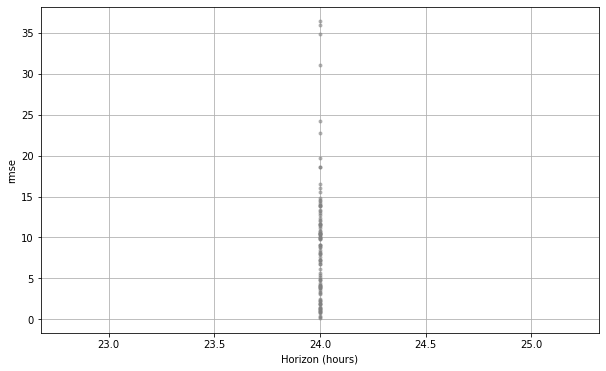

In [157]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')